In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
plt.style.use('fivethirtyeight')

import sympy as s
import csv
s.init_printing(use_latex='mathjax') # print sympy equations in MathJAX (for Jupyter)

def ll(a, b):
    return (a*b) / (a + b)

In [2]:
def parse(file, real_or_complex):
    with open('%s.csv' % file, 'r') as csvfile:
        next(csvfile)
        csvreader = csv.reader(csvfile, delimiter=',')
        data = []
        idsdata = []
        # Format is Ids, Vgs(L=45n), Ids, Vgs(L=90n), Ids, ...
        for row in csvreader:
            if (real_or_complex):
                val = list(map(lambda x: float(x), row[1::2]))
            else:
                val_real = list(map(lambda x: float(x), row[1::3]))
                val_imag = list(map(lambda x: float(x), row[2::3]))
                val = list(map(lambda n: np.abs(n[0] + n[1]*1j), zip(val_real, val_imag)))
            ids = float(row[0])
            data.append(val)
            idsdata.append(ids)
        return (np.array(idsdata), np.array(data))

In [3]:
# Gather data from ADE for Vgs, av0, gm vs Ids (for 4 different lengths = 45n, 90n, 135n, 1u=1000n)
(ids, vgs) = parse('vgs', True)
(ids, av0) = parse('av0', False)
(ids, gm) = parse('gm', False)
## WARNING: vstar is indexed row-wise, not column-wise like the above entries
vstar = [list(map(lambda n: 2*n[0]/n[1], zip(ids, gm[:,l]))) for l in range(4)]

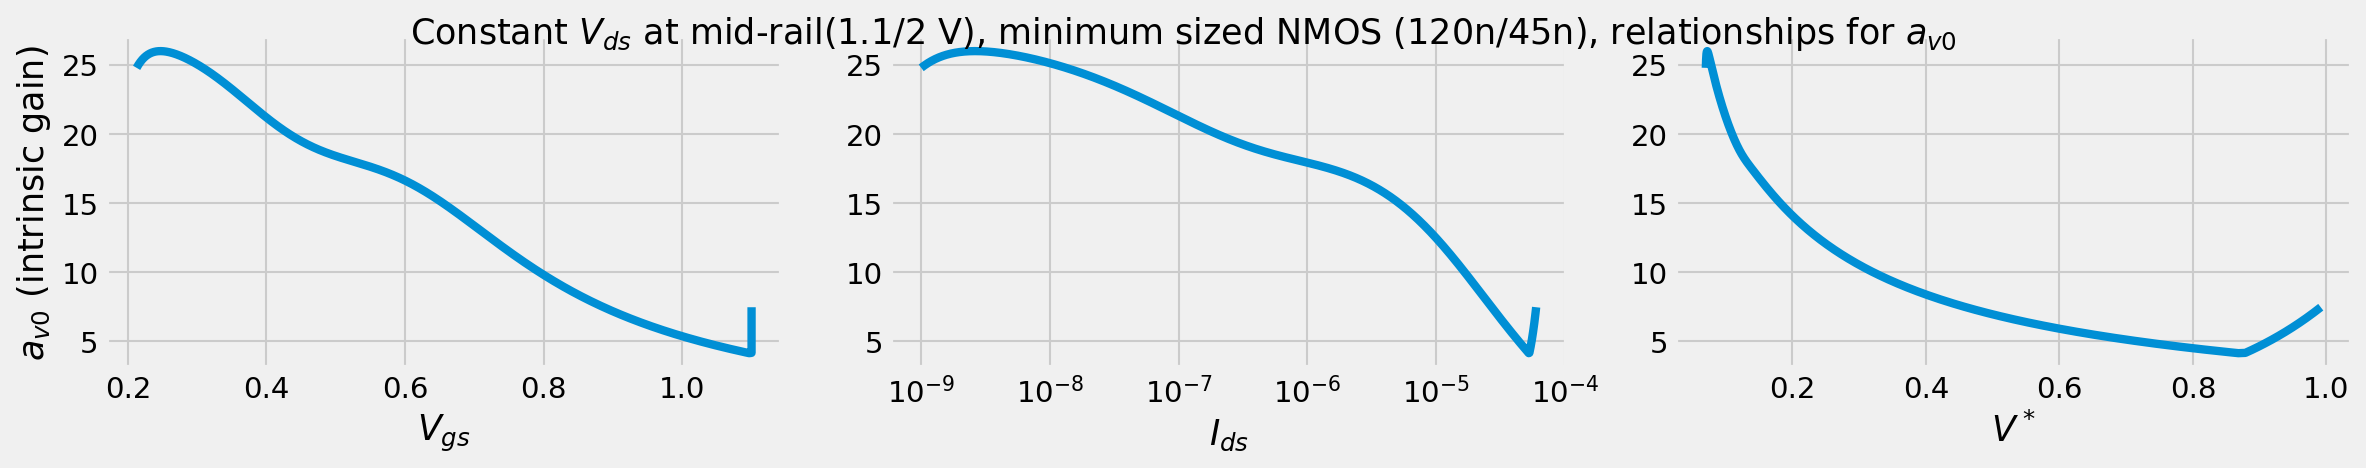

In [7]:
w, h = figaspect(1/5)
fig, ax = plt.subplots(1, 3, figsize=(w,h))

ax[0].plot(vgs[:,0], av0[:,0])
ax[0].set_xlabel('$V_{gs}$')
ax[0].set_ylabel('$a_{v0}$ (intrinsic gain)')
ax[1].ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)
ax[1].semilogx(ids, av0[:,0])
ax[1].set_xlabel('$I_{ds}$')
ax[2].plot(vstar[0], av0[:,0])
ax[2].set_xlabel('$V^*$')
fig.suptitle('Constant $V_{ds}$ at mid-rail(1.1/2 V), minimum sized NMOS (120n/45n), relationships for $a_{v0}$')
plt.tight_layout()
fig.savefig('figs/problem4.png', dpi=300)

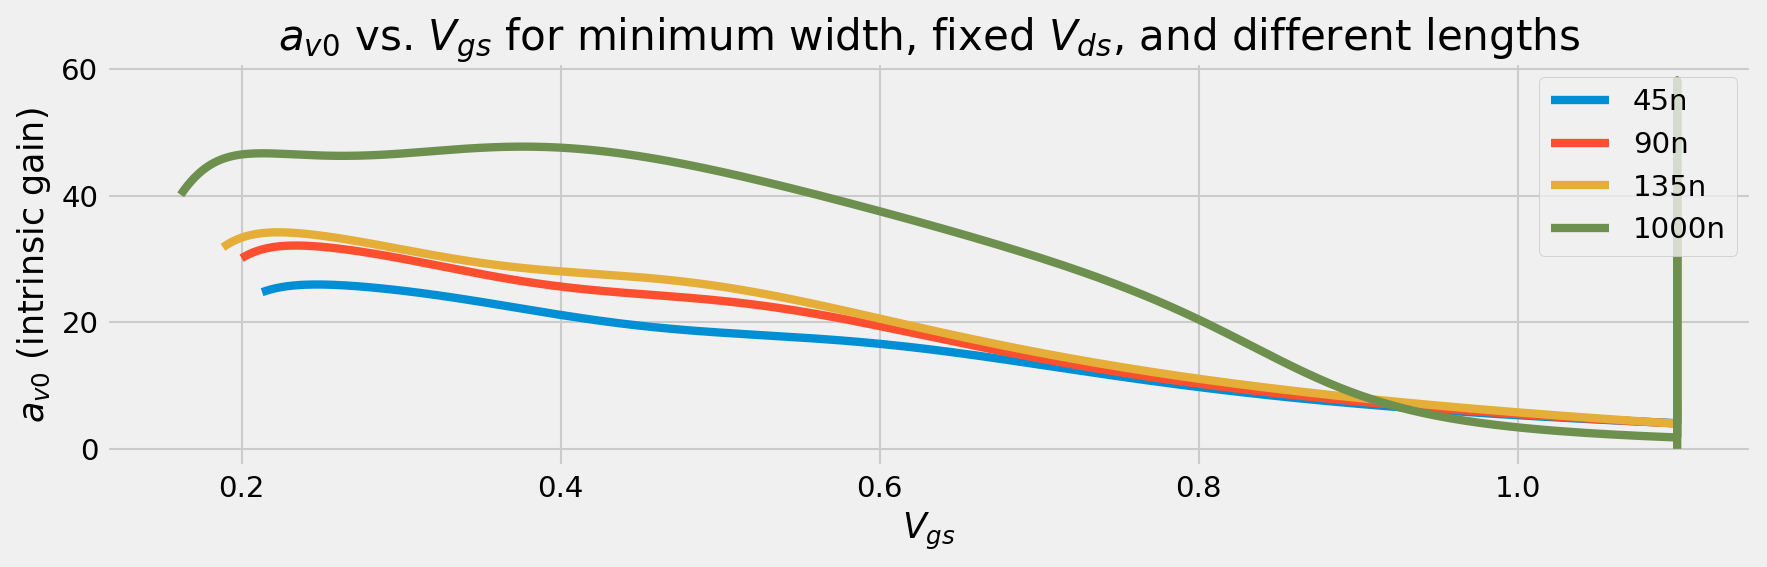

In [8]:
w, h = figaspect(1/3)
fig, ax = plt.subplots(figsize=(w,h))
[plt.plot(vgs[:,l], av0[:,l]) for l in range(4)]
plt.legend(['45n', '90n', '135n', '1000n'])
plt.ylabel('$a_{v0}$ (intrinsic gain)')
plt.xlabel('$V_{gs}$')
plt.title('$a_{v0}$ vs. $V_{gs}$ for minimum width, fixed $V_{ds}$, and different lengths')
plt.tight_layout()
fig.savefig('figs/problem5.png', dpi=300)

[3.94413875e+04 4.43962292e-01]


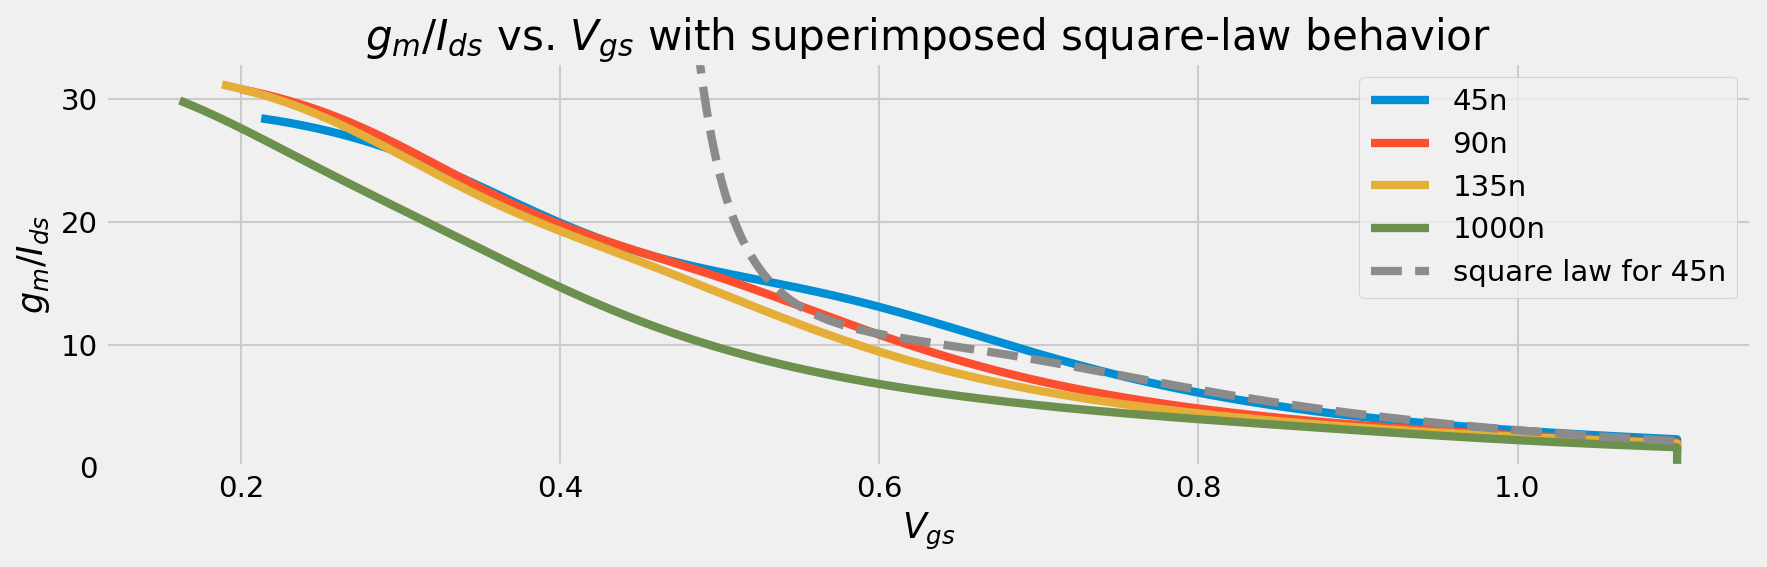

In [9]:
w, h = figaspect(1/3)
fig, ax = plt.subplots(figsize=(w,h))
[plt.plot(vgs[:,l], np.divide(gm[:,l], ids)) for l in range(4)]
plt.ylabel('$g_m / I_{ds}$')
plt.xlabel('$V_{gs}$')
plt.title('$g_m / I_{ds}$ vs. $V_{gs}$ with superimposed square-law behavior')
plt.ylim((0, 33))

from functools import partial
from scipy.optimize import curve_fit
def square_law(Vgs, k, Vth, W, L, Vds):
    return k*(W/L) * (Vgs - Vth)**2#(((Vgs - Vth) * Vds) - (Vds**2)/2)
min_fn = partial(square_law, W=120e-9, L=45-9, Vds=1.1/2)

match_range = 500
popt, pcov = curve_fit(min_fn, vgs[match_range:,0], ids[match_range:], p0=[5e-6, .350])
print(popt)
plt.plot(vgs[match_range:,0], np.divide(gm[match_range:,0], min_fn(vgs[match_range:,0], popt[0], popt[1])), '--')
plt.legend(['45n', '90n', '135n', '1000n', 'square law for 45n'])
plt.tight_layout()
fig.savefig('figs/problem8.png', dpi=300)

[3.94413875e+04 4.43962292e-01]


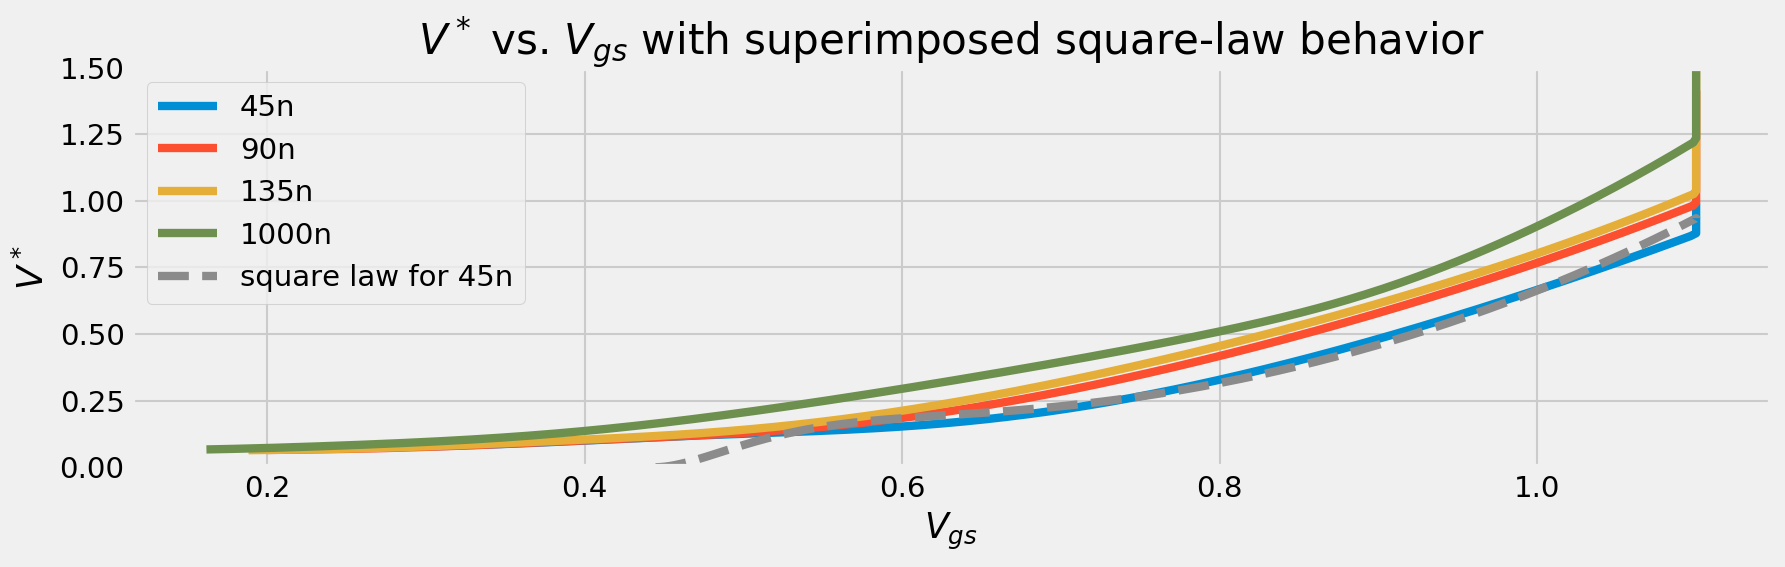

In [94]:
w, h = figaspect(1/3)
fig, ax = plt.subplots(figsize=(w,h))
[plt.plot(vgs[:,l], vstar[l]) for l in range(4)]
plt.ylabel('$V^*$')
plt.xlabel('$V_{gs}$')
plt.title('$V^*$ vs. $V_{gs}$ with superimposed square-law behavior')
plt.ylim((0, 1.5))

match_range = 500
popt, pcov = curve_fit(min_fn, vgs[match_range:,0], ids[match_range:], p0=[5e-6, .350])
print(popt)
plt.plot(vgs[match_range:,0], np.divide(2 * min_fn(vgs[match_range:,0], popt[0], popt[1]), gm[match_range:,0]), '--')
plt.legend(['45n', '90n', '135n', '1000n', 'square law for 45n'])
plt.tight_layout()
fig.savefig('figs/problem9.png', dpi=300)

In [19]:
def ft_parse():
    fT = []
    ids_fT = []
    for file in ['45n', '90n', '135n', '1000n']:
        with open('ft_%s.csv' % file, 'r') as csvfile:
            next(csvfile)
            csvreader = csv.reader(csvfile, delimiter=',')
            data = []
            idsdata = []
            # Format is Ids, cross(IF(drain), 1) (i.e. fT)
            for row in csvreader:
                val = float(row[1])
                ids = float(row[0])
                data.append(val)
                idsdata.append(ids)
            fT.append(data)
            ids_fT.append(idsdata)
    return (np.array(ids_fT[0]), np.array(fT))
(ids_fT, fT) = ft_parse()

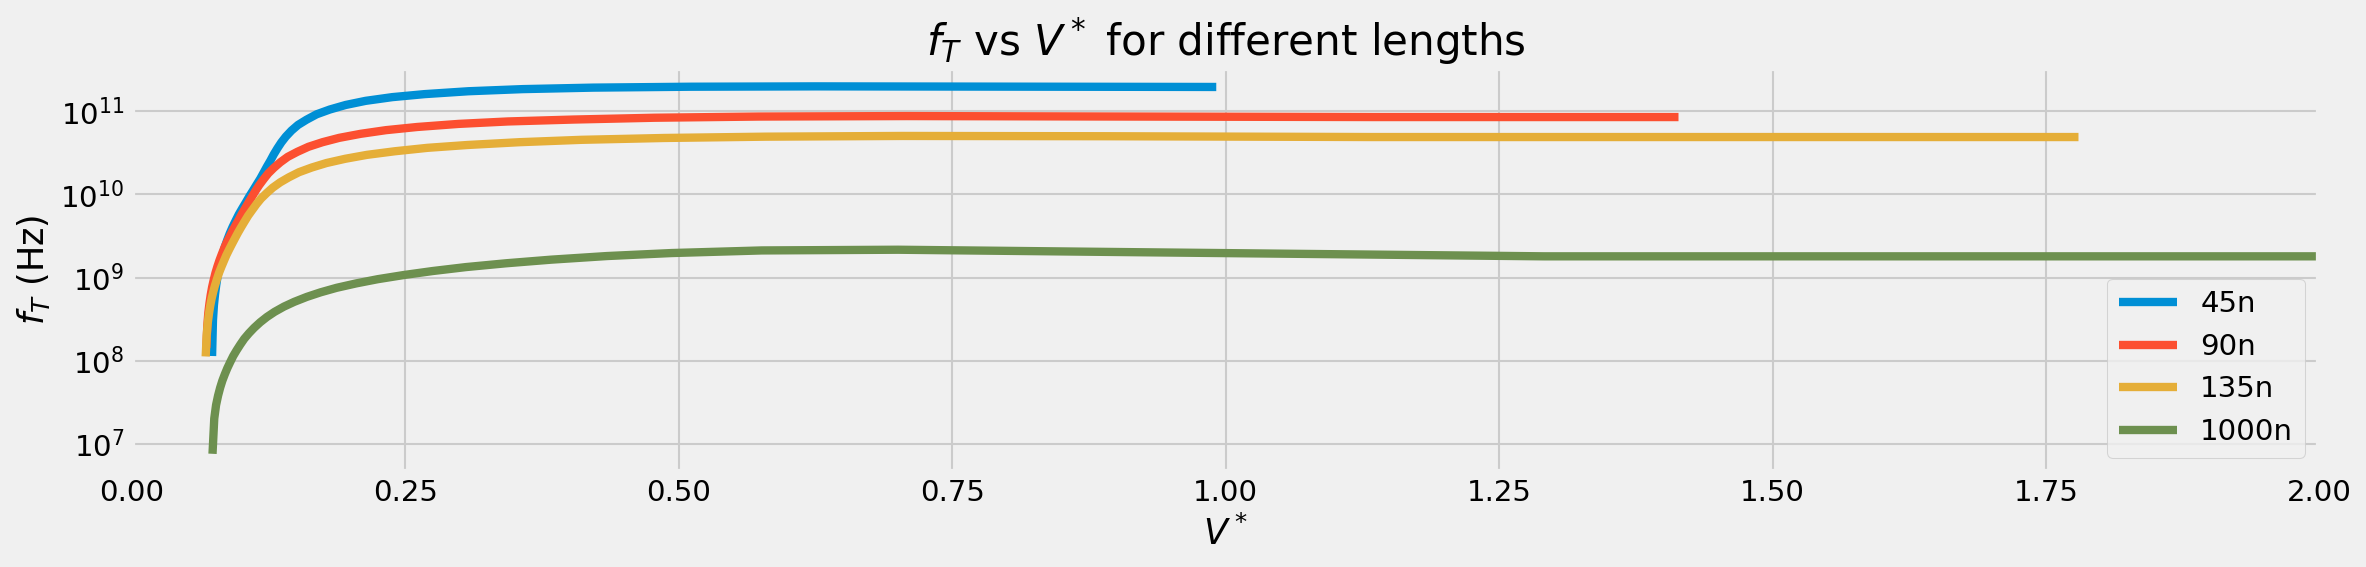

In [61]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    #return array[idx]
    return idx

# Plot fT vs Vstar for different lengths
w, h = figaspect(1/4)
fig, ax = plt.subplots(figsize=(w,h))
for L in range(4):
    vstar_fT = list(map(lambda x: vstar[L][find_nearest(ids, x)], ids_fT))
    plt.semilogy(vstar_fT, fT[L])
plt.xlim((0, 2))
plt.legend(['45n', '90n', '135n', '1000n'])
plt.xlabel('$V^*$')
plt.ylabel('$f_T$ (Hz)')
plt.title('$f_T$ vs $V^*$ for different lengths')
plt.tight_layout()
fig.savefig('figs/problem10.png', dpi=300)

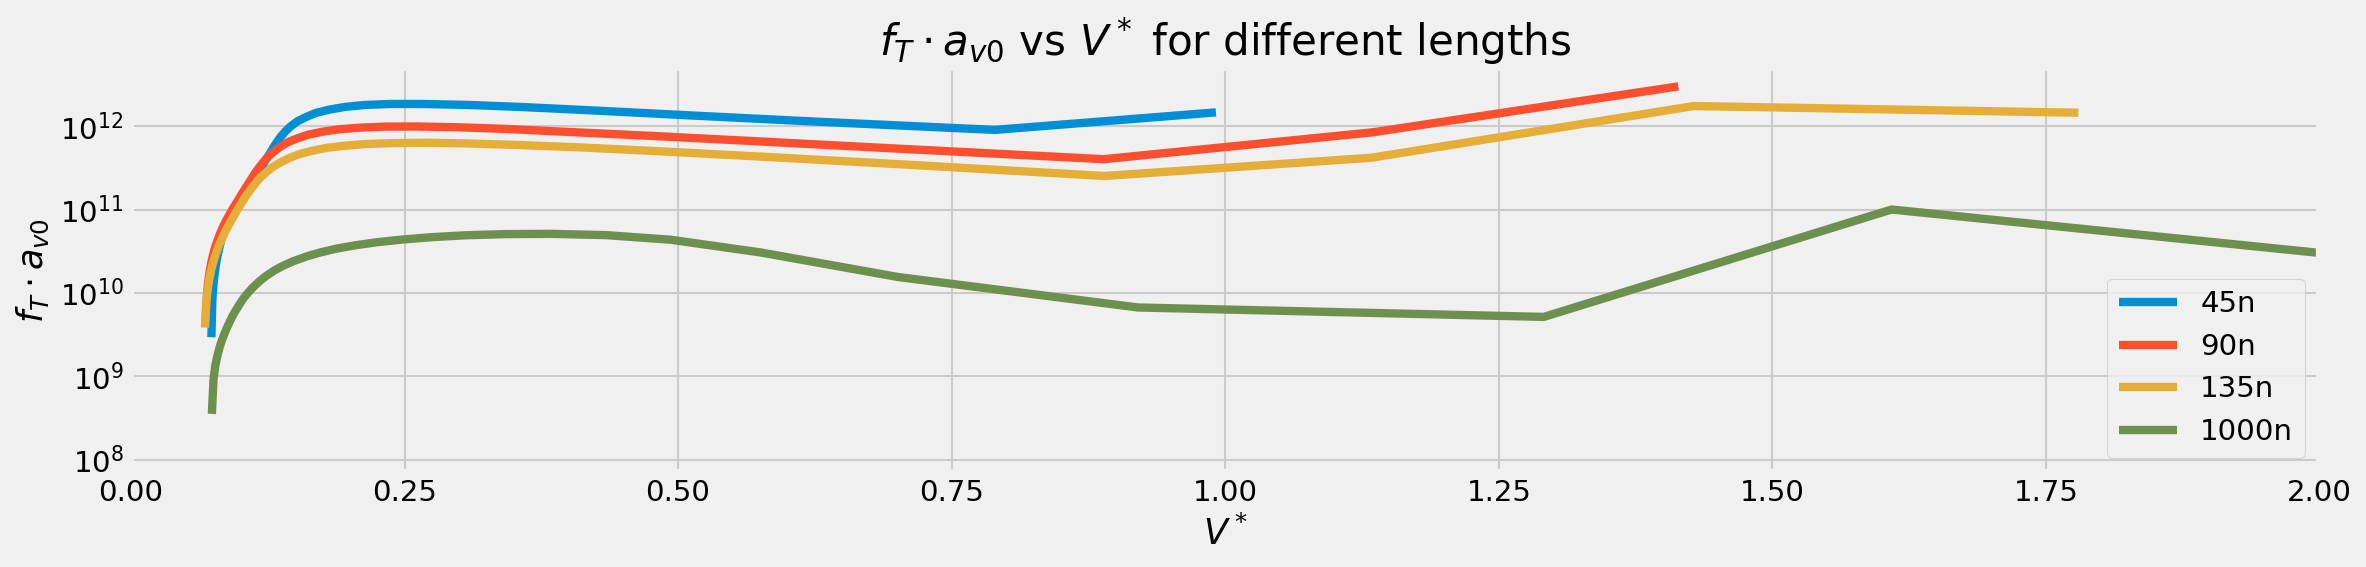

In [62]:
# Plot product of fT and av0 vs Vstar for different lengths
w, h = figaspect(1/4)
fig, ax = plt.subplots(figsize=(w,h))
for L in range(4):
    vstar_fT = list(map(lambda x: vstar[L][find_nearest(ids, x)], ids_fT))
    av0_L = av0[:,L]
    av0_fT = list(map(lambda x: av0_L[find_nearest(ids, x)], ids_fT))
    plt.semilogy(vstar_fT, np.multiply(fT[L], np.array(av0_fT)))
plt.xlim((0, 2))
plt.legend(['45n', '90n', '135n', '1000n'])
plt.xlabel('$V^*$')
plt.ylabel('$f_T \cdot a_{v0}$')
plt.title('$f_T \cdot a_{v0}$ vs $V^*$ for different lengths')
plt.tight_layout()
fig.savefig('figs/problem11.png', dpi=300)

In [67]:
def parse_C(file):
    with open('c_%s.csv' % file, 'r') as csvfile:
        next(csvfile)
        csvreader = csv.reader(csvfile, delimiter=',')
        idsdata = []
        vgsdata = []
        cgsdata = []
        cgddata = []
        cgbdata = []
        # Format is Ids, Vgs, Ids, Cgs, Ids, Cgd, Ids, Cgb
        for row in csvreader:
            ids = float(row[0])
            vgs = float(row[1])
            cgs = float(row[3])
            cgd = float(row[5])
            cgb = float(row[7])
            idsdata.append(ids)
            vgsdata.append(vgs)
            cgsdata.append(cgs)
            cgddata.append(cgd)
            cgbdata.append(cgb)
        return (np.array(idsdata), np.array(vgsdata), np.array(cgsdata), np.array(cgddata), np.array(cgbdata))

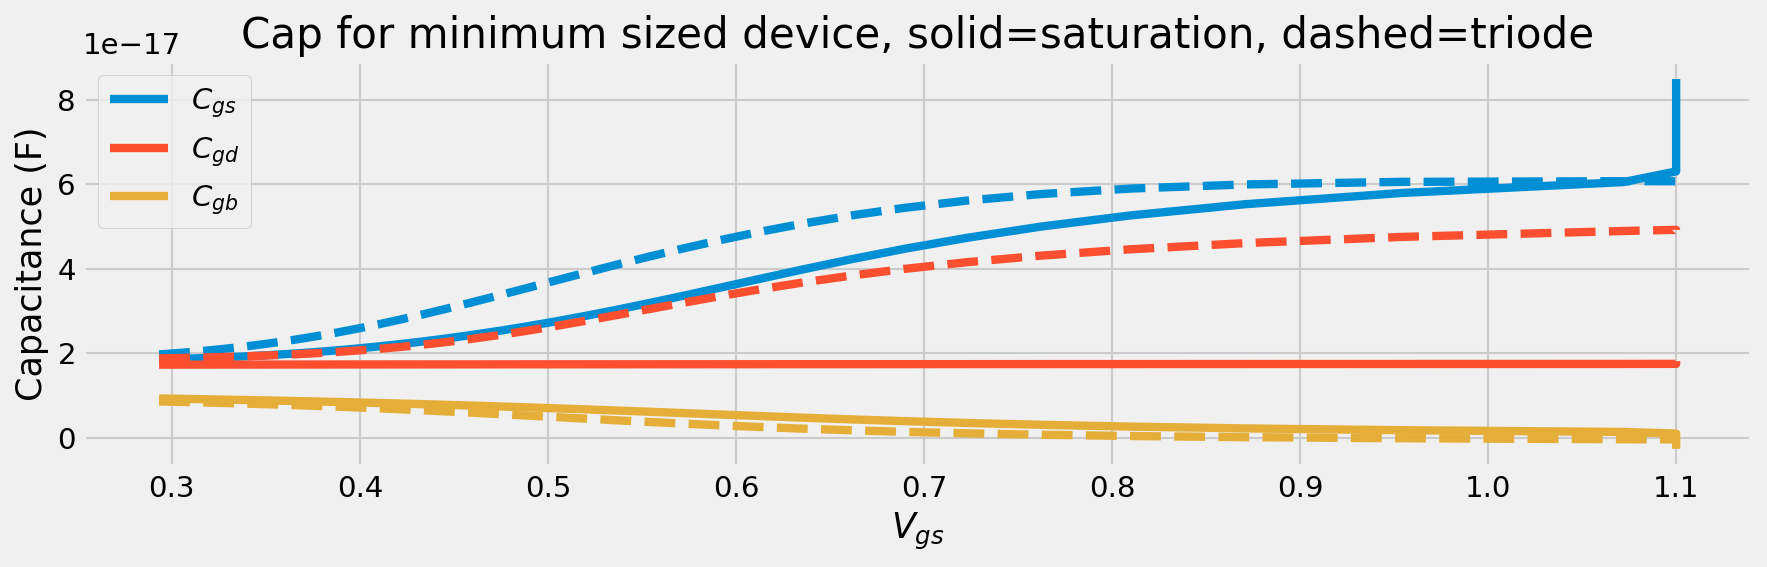

In [93]:
(ids_C, vgs_C, cgs_900, cgd_900, cgb_900) = parse_C('900m')
(ids_C, vgs_C, cgs_200, cgd_200, cgb_200) = parse_C('200m')

w, h = figaspect(1/3)
fig, ax = plt.subplots(figsize=(w,h))

plt.plot(vgs_C, cgs_900, color='#008fd5')
plt.plot(vgs_C, cgd_900, color='#fc4f30')
plt.plot(vgs_C, cgb_900, color='#e5ae38')
plt.xlabel('$V_{gs}$')
plt.ylabel('Capacitance (F)')

plt.plot(vgs_C, cgs_200, '--', color='#008fd5')
plt.plot(vgs_C, cgd_200, '--', color='#fc4f30')
plt.plot(vgs_C, cgb_200, '--', color='#e5ae38')
plt.legend(['$C_{gs}$', '$C_{gd}$', '$C_{gb}$'])
plt.title('Cap for minimum sized device, solid=saturation, dashed=triode')
plt.tight_layout()
plt.savefig('figs/problem7.png', dpi=300)